In [385]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [386]:
from pySIVAK import pySIVAK

In [387]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
import itertools
import json

In [388]:
inputdir = Path(r'../../data_results')
settingsdir = Path('Invoer')
outputdir = Path('Vergelijking_simulaties')

# Set scenario's

In [389]:
with open(settingsdir / 'settings.json') as f:
      settings = json.load(f)
        
with open(settingsdir / 'simulations.json') as f:
      simulations = json.load(f)

In [390]:
all_simulation_names = [name for lock, scenarios in simulations.items() for id,name in scenarios.items()]

In [391]:
# Compute max waiting time, based on scenario-name
maximum_waiting_time = {s: float(s.split(' ')[-1]) / 60 if s.startswith("R ") else 9999 for s in all_simulation_names }

# Effect of replications

In [392]:
# Read instances for all runs in dict
lock = 'Maasbracht'
scenario = 'SLMSBR KBN 0 - Base, Area 200 Rep'
name = simulations[lock][scenario]

summary_file =       inputdir / lock / 'KPI LockChambers Summary' / f'KPI_LockChambers_Summary_Avg ({scenario}).xlsx'
ships_file =         None
levelings_file =     inputdir / lock / 'Log Locks Leveling' / f'Log Locks Leveling ({scenario}).xlsx'
transit_times_file = inputdir / lock / 'Log Locks Transit Times' / f'Log Locks Transit Times ({scenario}).xlsx'

s = pySIVAK(levelings_file, transit_times_file, ships_file, summary_file)

s.correction_waitingtimes_without_new_arrivals(maximum_waiting_time=maximum_waiting_time[name])
s.correction_leveling_without_utilization()
s.correction_waterloss(water_plane=water_plane[lock], dH=dH[lock], downward_leveling_side=1, correct_ship_volume=False)

s.name = name

FileNotFoundError: [Errno 2] No such file or directory: '..\\..\\data_results\\Maasbracht\\Log Locks Leveling\\Log Locks Leveling (SLMSBR KBN 0 - Base, Area 200 Rep).xlsx'

In [51]:
from copy import deepcopy

In [131]:
passage_time = {}
passage_time_sunday = {}
passage_time_sunday_13h = {}
for r in np.arange(0, s.replications, 1):  
    s_repl = deepcopy(s)
    s_repl.select_replications([r+1])

    passage_time[r] = s_repl.transit_times['Passage time (hours)'].mean()
    passage_time_sunday[r] = s_repl.transit_times.loc[s_repl.transit_times['Time'].dt.weekday == 6]['Passage time (hours)'].mean()
    passage_time_sunday_13h[r] = s_repl.transit_times.loc[(s_repl.transit_times['Time'].dt.weekday == 6) & (s_repl.transit_times['Time'].dt.hour == 13)]['Passage time (hours)'].mean()

In [135]:
passage_time = pd.Series(passage_time) * 60
passage_time_norm = (passage_time - passage_time.mean()) / passage_time.std()

passage_time_sunday = pd.Series(passage_time_sunday) * 60
passage_time_sunday_norm = (passage_time_sunday - passage_time_sunday.mean()) / passage_time_sunday.std()

passage_time_sunday_13h = pd.Series(passage_time_sunday_13h) * 60
passage_time_sunday_13h_norm = (passage_time_sunday_13h - passage_time_sunday_13h.mean()) / passage_time_sunday_13h.std()

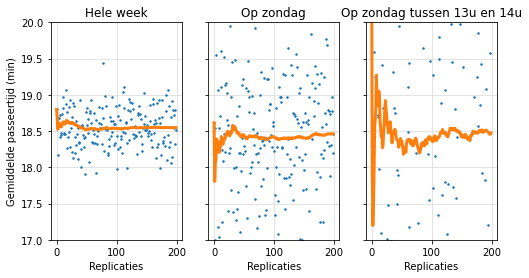

In [213]:
f, ax = plt.subplots(ncols=3, figsize=(8, 4), sharey=True)
plt.sca(ax[0])
passage_time.plot(marker='.', ls='none', markersize=3)
passage_time.rolling(window=200, min_periods=0).mean().plot(ls='-', lw=3)

plt.ylabel('Gemiddelde passeertijd (min)')
plt.title('Hele week')
plt.grid(c='#ddd')
plt.xlabel('Replicaties')

plt.sca(ax[1])
passage_time_sunday.plot(marker='.', ls='none', markersize=3)
passage_time_sunday.rolling(window=200, min_periods=0).mean().plot(ls='-', lw=3)

plt.title('Op zondag')
plt.grid(c='#ddd')
plt.xlabel('Replicaties')

plt.sca(ax[2])
passage_time_sunday_13h.plot(marker='.', ls='none', markersize=3)
passage_time_sunday_13h.rolling(window=200, min_periods=0).mean().plot(ls='-', lw=3)

plt.title('Op zondag tussen 13u en 14u')
plt.grid(c='#ddd')
plt.xlabel('Replicaties')

plt.ylim(17, 20)

plt.savefig(    outputdir / f'Replicaties.png', bbox_inches='tight', dpi=150)
plt.savefig(    outputdir / f'Replicaties.svg', bbox_inches='tight')


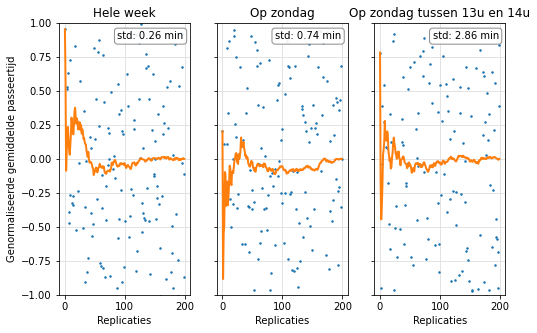

In [214]:
f, ax = plt.subplots(ncols=3, figsize=(8, 5), sharey=True)
plt.sca(ax[0])
passage_time_norm.plot(marker='.', ls='none', markersize=3)
passage_time_norm.rolling(window=200, min_periods=0).mean().plot(ls='-', lw=2)

plt.ylabel('Genormaliseerde gemiddelde passeertijd')
plt.title('Hele week')
plt.grid(c='#ddd')
plt.annotate(f'std: {passage_time.std():.2f} min', (0.95, 0.97), xycoords='axes fraction', ha='right', va='top', bbox= dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9))
plt.xlabel('Replicaties')
plt.sca(ax[1])
passage_time_sunday_norm.plot(marker='.', ls='none', markersize=3)
passage_time_sunday_norm.rolling(window=200, min_periods=0).mean().plot(ls='-', lw=2)

plt.title('Op zondag')
plt.grid(c='#ddd')
plt.annotate(f'std: {passage_time_sunday.std():.2f} min', (0.95, 0.97), xycoords='axes fraction', ha='right', va='top', bbox= dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9))
plt.xlabel('Replicaties')

plt.sca(ax[2])
passage_time_sunday_13h_norm.plot(marker='.', ls='none', markersize=3)
passage_time_sunday_13h_norm.rolling(window=200, min_periods=0).mean().plot(ls='-', lw=2)

plt.title('Op zondag tussen 13u en 14u')
plt.grid(c='#ddd')
plt.annotate(f'std: {passage_time_sunday_13h.std():.2f} min', (0.95, 0.97), xycoords='axes fraction', ha='right', va='top', bbox= dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9))
plt.xlabel('Replicaties')
plt.ylim(-1, 1)


plt.savefig(    outputdir / f'Replicaties_norm.png', bbox_inches='tight', dpi=150)
plt.savefig(    outputdir / f'Replicaties_norm.svg', bbox_inches='tight')


# Aanpassingen vloot

In [393]:
# Read instances for all runs in dict
lock = 'Maasbracht'
scenario_names = ['REF', 'Beroepsvaart +10%', 'Beroepsvaart +20%', 'Recreatievaart -50%','Recreatievaart -100%',]
S = {}
for name in scenario_names:
    
    scenario = {v:k for k,v in simulations[lock].items()}[name]
    
    summary_file =       inputdir / lock / 'KPI LockChambers Summary' / f'KPI_LockChambers_Summary_Avg ({scenario}).xlsx'
    ships_file =         inputdir / lock / 'Log Generated Ships' / f'Log Generated Ships ({scenario}).xlsx'
    levelings_file =     inputdir / lock / 'Log Locks Leveling' / f'Log Locks Leveling ({scenario}).xlsx'
    transit_times_file = inputdir / lock / 'Log Locks Transit Times' / f'Log Locks Transit Times ({scenario}).xlsx'

    s = pySIVAK(levelings_file, transit_times_file, ships_file, summary_file)

    s.correction_waitingtimes_without_new_arrivals(maximum_waiting_time=maximum_waiting_time[name])
    s.correction_leveling_without_utilization()
    s.correction_waterloss(water_plane=water_plane[lock], dH=dH[lock], downward_leveling_side=1, correct_ship_volume=False)

    s.name = name
    
    S[name] = s

FileNotFoundError: [Errno 2] No such file or directory: '..\\..\\data_results\\Maasbracht\\Log Locks Transit Times\\Log Locks Transit Times (SLMSBR KBN 0 - Base, Area).xlsx'

In [207]:
T = {n:s.transit_times['Passage time (hours)'].mean() * 60 for n,s in S.items()}
W = {n:s.waterloss_per_hour_per_day().mean().mean() for n,s in S.items()}

In [208]:
D = pd.DataFrame({'Passeertijd (min)': T, 'Schutdebiet (m3/s)': W})

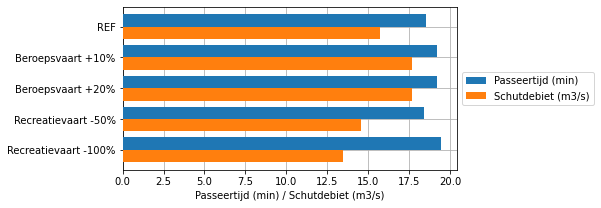

In [209]:
D.plot.barh(width=0.8, zorder=3, figsize=(6,3))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.gca().invert_yaxis()
plt.xlabel('Passeertijd (min) / Schutdebiet (m3/s)')

plt.savefig(    outputdir / f'Vloot.png', bbox_inches='tight', dpi=150)
plt.savefig(    outputdir / f'Vloot.svg', bbox_inches='tight')
D.to_csv(       outputdir / f'Vloot.csv')

### Effect regimes 

In [217]:
# Read instances for all runs in dict
lock = 'Maasbracht'
scenario_names = ['REF', 'R 40 80 30', 'R 60 80 90']
S = {}
for name in scenario_names:
    
    scenario = {v:k for k,v in simulations[lock].items()}[name]
    
    summary_file =       inputdir / lock / 'KPI LockChambers Summary' / f'KPI_LockChambers_Summary_Avg ({scenario}).xlsx'
    ships_file =         inputdir / lock / 'Log Generated Ships' / f'Log Generated Ships ({scenario}).xlsx'
    levelings_file =     inputdir / lock / 'Log Locks Leveling' / f'Log Locks Leveling ({scenario}).xlsx'
    transit_times_file = inputdir / lock / 'Log Locks Transit Times' / f'Log Locks Transit Times ({scenario}).xlsx'

    s = pySIVAK(levelings_file, transit_times_file, ships_file, summary_file)

    s.correction_waitingtimes_without_new_arrivals(maximum_waiting_time=maximum_waiting_time[name])
    s.correction_leveling_without_utilization()
    s.correction_waterloss(water_plane=water_plane[lock], dH=dH[lock], downward_leveling_side=1, correct_ship_volume=False)

    s.name = name
    
    S[name] = s

In [220]:
T = {n:s.transit_times.groupby('Class')['Passage time (hours)'].mean() * 60 for n,s in S.items()}
T = pd.DataFrame(T)

In [232]:
def diff(df):
    # Adjusted to minimise at 0 and still compute the + correct
    df2 = df.copy()
    for c1, c2 in zip(df.columns[1:], df.columns[:-1]):
        df2[c1] = df[c1] - df2.cumsum(axis=1)[c2]
        df2.loc[df2[c1] < 0.00, c1] = 0
    return df2 

plotdata = diff(T)

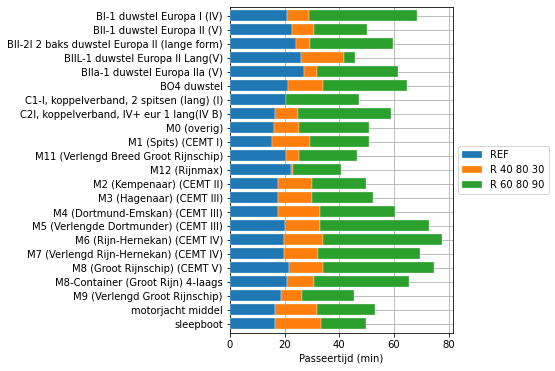

In [246]:
plotdata.plot.barh(figsize=(4, 6), zorder=3, stacked=True, edgecolor='w',
                           linewidth=0.3, width=0.8)
plt.xlabel('Passeertijd (min)')
plt.ylabel('')
plt.grid()
plt.gca().invert_yaxis()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig(    outputdir / f'Schutregime_passeertijd.png', bbox_inches='tight', dpi=150)
plt.savefig(    outputdir / f'Schutregime_passeertijd.svg', bbox_inches='tight')
T.to_csv(       outputdir / f'Schutregime_passeertijd.csv')

# Effect daggemiddelde

In [377]:
# Read instances for all runs in dict
locks = ['Born', 'Maasbracht', 'Heel']
# name = 'R 60 80 90'
# name = 'REF'
name = 'R 40 80 30'

S = {}

for lock in locks:
    scenario = {v:k for k,v in simulations[lock].items()}[name]


    summary_file =       inputdir / lock / 'KPI LockChambers Summary' / f'KPI_LockChambers_Summary_Avg ({scenario}).xlsx'
    ships_file =         inputdir / lock / 'Log Generated Ships' / f'Log Generated Ships ({scenario}).xlsx'
    levelings_file =     inputdir / lock / 'Log Locks Leveling' / f'Log Locks Leveling ({scenario}).xlsx'
    transit_times_file = inputdir / lock / 'Log Locks Transit Times' / f'Log Locks Transit Times ({scenario}).xlsx'

    s = pySIVAK(levelings_file, transit_times_file, ships_file, summary_file)

    s.correction_waitingtimes_without_new_arrivals(maximum_waiting_time=maximum_waiting_time[name])
    s.correction_leveling_without_utilization()
    s.correction_waterloss(water_plane=water_plane[lock], dH=dH[lock], downward_leveling_side=1, correct_ship_volume=False)
    S[lock] = s

In [378]:
kwetsbaarheid = {
    'Born': 0.06,  # cm / (m3/s * uur)
    'Maasbracht': 0.24,  # cm / (m3/s * uur)
    'Heel': 0.04  # cm / (m3/s * uur)
}

In [379]:
# def plot_waterstandsvariatie(lock):
#     Q = S[lock].waterloss_per_hour_per_day()
#     Q_daymean = Q.mean()

#     Q_deviation = Q.subtract(Q_daymean)
#     Q_deviation_cumsum = Q_deviation.cumsum(axis=0)

#     Q_deviation_cumsum.loc[24] = None

#     Q_deviation_cumsum = Q_deviation_cumsum.shift(1)
#     Q_deviation_cumsum.loc[0] = 0
    
#     waterstandsvariatie = (Q_deviation_cumsum * kwetsbaarheid[lock])
#     waterstandsvariatie.plot()
#     plt.grid(c='#DDD')
#     plt.ylabel('Waterstandsvariatie (cm)')
#     plt.title('Waterstandsvariatie bij daggemiddelde waterbeschikbaarheid')
#     plt.xlabel('Uur van de dag')
#     plt.legend(['Maandag','Dinsdag','Woensdag', 'Donderdag', 'Vrijdag', 'Zaterdag', 'Zondag'])
#     plt.autoscale(tight=True, axis='x')
#     return waterstandsvariatie

# for lock in locks:
#     plot_waterstandsvariatie(lock)

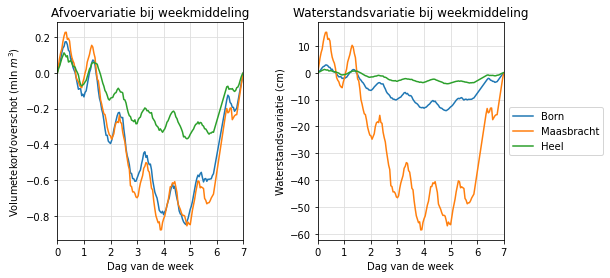

In [382]:
f, ax = plt.subplots(ncols=2, figsize=(8,4))
plt.subplots_adjust(wspace=0.4)
for lock in locks:
    Q = S[lock].waterloss_per_hour_per_day()
    Q_flatten = Q.stack().swaplevel().sort_index()
    Q_flatten.index = [(d-1) + h/24 for (d, h) in Q_flatten.index]
    Q_weekmean = Q_flatten.mean()

    Q_deviation = Q_flatten.subtract(Q_weekmean)
    Q_deviation_cumsum = Q_deviation.cumsum(axis=0)

    Q_deviation_cumsum.loc[7] = 0

    Q_deviation_cumsum = Q_deviation_cumsum.shift(1)
    Q_deviation_cumsum.loc[0] = 0
    
    (- Q_deviation_cumsum * 60 * 60 / 1e6).plot(ax=ax[0], label=lock, )

    waterstandsvariatie = (- Q_deviation_cumsum * kwetsbaarheid[lock])
    waterstandsvariatie.plot(label=lock, ax=ax[1])


plt.sca(ax[0])
plt.grid(c='#DDD')
plt.ylabel('Volumetekort/overschot (mln $m^3$)')
plt.title('Afvoervariatie bij weekmiddeling')
plt.xlabel('Dag van de week')
plt.autoscale(tight=True, axis='x')
plt.xticks(ticks=np.arange(0, 7.1, 1))    
    
plt.sca(ax[1])
plt.grid(c='#DDD')
plt.ylabel('Waterstandsvariatie (cm)')
plt.title('Waterstandsvariatie bij weekmiddeling')
plt.xlabel('Dag van de week')
plt.autoscale(tight=True, axis='x')
plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')
plt.xticks(ticks=np.arange(0, 7.1, 1))    

plt.savefig(    outputdir / f'Afvoer- en waterstandsvariatie bij weekmiddeling_{name}.png', bbox_inches='tight', dpi=150)
plt.savefig(    outputdir / f'Afvoer- en waterstandsvariatie bij weekmiddeling_{name}.svg', bbox_inches='tight')

In [384]:
29*0.6

17.4